In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# # data = 'In the town of Athy one Jeremy Lanigan \nbattered away till he hadnt a pound \nhis father he died and made him a man again \nleft a farm with ten acres of ground \nhe gave a grand party for friends a relations \nwho did not forget him when come to the will \nand if youll but listen Ill make your eyes glisten \nof rows and ructions at Lanigans Ball \nsix long months I spent in Dubilin \nsix long months doing nothin at all \nsix long months I spent in Dubilin \nlearning to dance for Lanigans Ball \nI stepped out I stepped in again \nI stepped out I stepped in again\nI stepped out I stepped in again \nlearning to dance for Lanigans Ball \nMyself to be sure got free invitaions\nfor all the nice boys and girls I did ask \nin less than 10 minutes the friends and relations \nwere dancing as merry as bee round a cask \nThere was lashing of punch and wine for the ladies \npotatoes and cakes there was bacon a tay\nthere were the OShaughnessys, Murphys, Walshes, OGradys\ncourtin the girls and dancing away\nthey were doing all kinds of nonsensical polkas \nall round the room in a whirly gig \nbut Julia and I soon banished their nonsense \nand tipped them a twist of a real Irish jig \nOh how that girl got mad on me \nand danced till youd think the ceilings would fall \nfor I spent three weeks at Brooks academy \nlearning to dance for Lanigans Ball CHORUS\nThe boys were all merry the girls were all hearty \ndancing away in couples and groups \ntill an accident happened young Terrance McCarthy \nput his right leg through Miss Finertys hoops \nThe creature she fainted and cried melia murder \ncried for her brothers and gathered them all \nCarmody swore that hed go no further \ntill hed have satisfaction at Lanigans Ball \nIn the midst of the row Miss Kerrigan fainted \nher cheeks at the same time as red as a rose \nsome of the boys decreed she was painted \nshe took a wee drop too much I suppose \nHer sweetheart Ned Morgan all powerful and able \nwhen he saw his fair colleen stretched out by the wall \nhe tore the left leg from under the table \nand smashed all the dishes at Lanigans Ball CHORUS\nBoy oh Boys tis then there was ructions \nmyself got a kick from big Phelam McHugh \nbut soon I replied to this kind introduction \nand kicked up a terrible hullaballoo \nold Casey the piper was near being strangled \nthey squeezed up his pipes bellows chanters and all \nthe girls in their ribbons they all got entangled \nand that put an end to Lanigans Ball CHORUS'
# corpus = data.lower().split('\n')

In [3]:
# copy a bunch of irish songs/rhymes
!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /home/ec2-user/ebs/data/nlp_data/irish-lyrics-eof.txt

--2020-08-20 07:34:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.217.15.80, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/home/ec2-user/ebs/data/nlp_data/irish-lyrics-eof.txt’

/home/ec2-user/ebs/ 100%[===================>]  67.35K  --.-KB/s    in 0.003s  

2020-08-20 07:34:55 (22.6 MB/s) - ‘/home/ec2-user/ebs/data/nlp_data/irish-lyrics-eof.txt’ saved [68970/68970]



In [4]:
f = open('/home/ec2-user/ebs/data/nlp_data/irish-lyrics-eof.txt', 'r')
data = f.read()
corpus = data.lower().split('\n')

# Text encoding

In [5]:
tokenizer = Tokenizer()  # create tokenizer instance
tokenizer.fit_on_texts(corpus)  # Encode corpus by creating a dictionary 
word_index = tokenizer.word_index  # return dictionary of corpus with keys as words and values as tokens
total_words = len(word_index) + 1  # add 1 to account for OOV

# print(word_index)
print('Total number of words in corpus:', total_words)

Total number of words in corpus: 2690


In [6]:
# Create all possible ngrams of corpus by extracting every possible word combinations
input_sequences = []
for line in corpus:
    word_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(word_list)):
        ngram_sequence = word_list[:i+1]
        input_sequences.append(ngram_sequence)
        
# Count max sequence length and pad input sequences to keep them of equal length
max_seqlen = max([len(x) for x in input_sequences])
padded_sequences = np.array(pad_sequences(input_sequences, maxlen = max_seqlen, padding='pre')) 

# QC pad_sequences
padded_sequences[10]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,  11,  15,
        31, 361,   8], dtype=int32)

# Create data and labels

In [7]:
# Create input sequences and corresponding predictions (labels) for training 
Xs, labels = padded_sequences[:,:-1], padded_sequences[:,-1]
print(Xs[10], labels[10])

# Convert labels to one-hot 
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

[  0   0   0   0   0   0   0   0   0   0   2  11  15  31 361] 8


# Model development

In [8]:
# build model using LSTM
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(total_words, 100, input_length=max_seqlen-1))
model1.add(tf.keras.layers.LSTM(64))
model1.add(tf.keras.layers.Dense(total_words, activation='softmax'))

# compile model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model1.summary()

# train model
history_model1 = model1.fit(Xs, ys, epochs=500, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           269000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 2690)              174850    
Total params: 486,090
Trainable params: 486,090
Non-trainable params: 0
_________________________________________________________________
Train on 12038 samples
Epoch 1/500
12038/12038 [==============================] - 8s 667us/sample - loss: 6.7601 - acc: 0.0641
Epoch 2/500
12038/12038 [==============================] - 4s 304us/sample - loss: 6.3150 - acc: 0.0664
Epoch 3/500
12038/12038 [==============================] - 4s 301us/sample - loss: 6.1995 - acc: 0.0758
Epoch 4/500
12038/12038 [====================

12038/12038 [==============================] - 4s 301us/sample - loss: 1.3140 - acc: 0.7184
Epoch 72/500
12038/12038 [==============================] - 4s 301us/sample - loss: 1.2919 - acc: 0.7238
Epoch 73/500
12038/12038 [==============================] - 4s 303us/sample - loss: 1.2716 - acc: 0.7256
Epoch 74/500
12038/12038 [==============================] - 4s 303us/sample - loss: 1.2510 - acc: 0.7309
Epoch 75/500
12038/12038 [==============================] - 4s 304us/sample - loss: 1.2307 - acc: 0.7354
Epoch 76/500
12038/12038 [==============================] - 4s 305us/sample - loss: 1.2122 - acc: 0.7407
Epoch 77/500
12038/12038 [==============================] - 4s 301us/sample - loss: 1.1935 - acc: 0.7422
Epoch 78/500
12038/12038 [==============================] - 4s 304us/sample - loss: 1.1778 - acc: 0.7458
Epoch 79/500
12038/12038 [==============================] - 4s 305us/sample - loss: 1.1574 - acc: 0.7501
Epoch 80/500
12038/12038 [==============================] - 4s 300us

12038/12038 [==============================] - 4s 300us/sample - loss: 0.5724 - acc: 0.8505
Epoch 149/500
12038/12038 [==============================] - 4s 301us/sample - loss: 0.5712 - acc: 0.8493
Epoch 150/500
12038/12038 [==============================] - 4s 299us/sample - loss: 0.5685 - acc: 0.8502
Epoch 151/500
12038/12038 [==============================] - 4s 302us/sample - loss: 0.5646 - acc: 0.8498
Epoch 152/500
12038/12038 [==============================] - 4s 299us/sample - loss: 0.5598 - acc: 0.8507
Epoch 153/500
12038/12038 [==============================] - 4s 300us/sample - loss: 0.5569 - acc: 0.8513
Epoch 154/500
12038/12038 [==============================] - 4s 315us/sample - loss: 0.5552 - acc: 0.8514
Epoch 155/500
12038/12038 [==============================] - 4s 300us/sample - loss: 0.5536 - acc: 0.8519
Epoch 156/500
12038/12038 [==============================] - 4s 302us/sample - loss: 0.5495 - acc: 0.8523
Epoch 157/500
12038/12038 [==============================] -

12038/12038 [==============================] - 4s 299us/sample - loss: 0.4593 - acc: 0.8589
Epoch 226/500
12038/12038 [==============================] - 4s 301us/sample - loss: 0.4588 - acc: 0.8578
Epoch 227/500
12038/12038 [==============================] - 4s 304us/sample - loss: 0.4578 - acc: 0.8584
Epoch 228/500
12038/12038 [==============================] - 4s 310us/sample - loss: 0.4599 - acc: 0.8589
Epoch 229/500
12038/12038 [==============================] - 4s 306us/sample - loss: 0.4584 - acc: 0.8594
Epoch 230/500
12038/12038 [==============================] - 4s 300us/sample - loss: 0.4597 - acc: 0.8591
Epoch 231/500
12038/12038 [==============================] - 4s 308us/sample - loss: 0.4592 - acc: 0.8563
Epoch 232/500
12038/12038 [==============================] - 4s 298us/sample - loss: 0.4609 - acc: 0.8582
Epoch 233/500
12038/12038 [==============================] - 4s 300us/sample - loss: 0.4564 - acc: 0.8583
Epoch 234/500
12038/12038 [==============================] -

12038/12038 [==============================] - 4s 319us/sample - loss: 0.4361 - acc: 0.8604
Epoch 303/500
12038/12038 [==============================] - 4s 302us/sample - loss: 0.4367 - acc: 0.8593
Epoch 304/500
12038/12038 [==============================] - 4s 301us/sample - loss: 0.4368 - acc: 0.8595
Epoch 305/500
12038/12038 [==============================] - 4s 301us/sample - loss: 0.4366 - acc: 0.8584
Epoch 306/500
12038/12038 [==============================] - 4s 300us/sample - loss: 0.4382 - acc: 0.8589
Epoch 307/500
12038/12038 [==============================] - 4s 300us/sample - loss: 0.4365 - acc: 0.8593
Epoch 308/500
12038/12038 [==============================] - 4s 301us/sample - loss: 0.4369 - acc: 0.8580
Epoch 309/500
12038/12038 [==============================] - 4s 298us/sample - loss: 0.4361 - acc: 0.8593
Epoch 310/500
12038/12038 [==============================] - 4s 298us/sample - loss: 0.4369 - acc: 0.8578
Epoch 311/500
12038/12038 [==============================] -

12038/12038 [==============================] - 4s 307us/sample - loss: 0.4287 - acc: 0.8579
Epoch 380/500
12038/12038 [==============================] - 4s 302us/sample - loss: 0.4296 - acc: 0.8602
Epoch 381/500
12038/12038 [==============================] - 4s 301us/sample - loss: 0.4310 - acc: 0.8582
Epoch 382/500
12038/12038 [==============================] - 4s 298us/sample - loss: 0.4329 - acc: 0.8586
Epoch 383/500
12038/12038 [==============================] - 4s 305us/sample - loss: 0.4321 - acc: 0.8590
Epoch 384/500
12038/12038 [==============================] - 4s 304us/sample - loss: 0.4301 - acc: 0.8579
Epoch 385/500
12038/12038 [==============================] - 4s 303us/sample - loss: 0.4297 - acc: 0.8587
Epoch 386/500
12038/12038 [==============================] - 4s 302us/sample - loss: 0.4293 - acc: 0.8590
Epoch 387/500
12038/12038 [==============================] - 4s 304us/sample - loss: 0.4314 - acc: 0.8584
Epoch 388/500
12038/12038 [==============================] -

12038/12038 [==============================] - 4s 306us/sample - loss: 0.4252 - acc: 0.8590
Epoch 457/500
12038/12038 [==============================] - 4s 301us/sample - loss: 0.4263 - acc: 0.8590
Epoch 458/500
12038/12038 [==============================] - 4s 305us/sample - loss: 0.4292 - acc: 0.8585
Epoch 459/500
12038/12038 [==============================] - 4s 303us/sample - loss: 0.4367 - acc: 0.8568
Epoch 460/500
12038/12038 [==============================] - 4s 309us/sample - loss: 0.4315 - acc: 0.8575
Epoch 461/500
12038/12038 [==============================] - 4s 317us/sample - loss: 0.4279 - acc: 0.8589
Epoch 462/500
12038/12038 [==============================] - 4s 303us/sample - loss: 0.4254 - acc: 0.8584
Epoch 463/500
12038/12038 [==============================] - 4s 306us/sample - loss: 0.4243 - acc: 0.8592
Epoch 464/500
12038/12038 [==============================] - 4s 301us/sample - loss: 0.4242 - acc: 0.8599
Epoch 465/500
12038/12038 [==============================] -

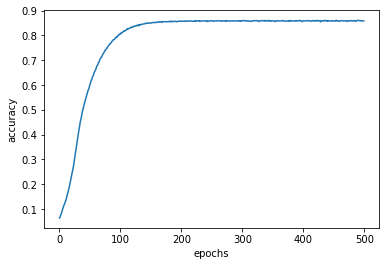

In [14]:
import matplotlib.pyplot as plt

plt.plot(history_model1.history['acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Prediction stage

In [10]:
# Predict next word progressively

seed_text = 'Courtin pretty maids in the evening'
next_words = 10

for _ in range(next_words):
    testword_list = tokenizer.texts_to_sequences([seed_text])[0] # tokenize text to a dictionary
    testword_list = pad_sequences([testword_list], maxlen=max_seqlen-1, padding='pre')
    print(testword_list)
    # Note: maxlen is one word shorter to match training sequence length
    predicted = model1.predict_classes(testword_list, verbose=0)
    
    output_word = ''
    for word, index in tokenizer.word_index.items():
        if index == predicted:  # Note: if predicted label matches index, extract corresponding word and break
            output_word = word
            break
    seed_text += ' ' + output_word
print(seed_text)

[[   0    0    0    0    0    0    0    0    0 1036  187 2686    8    1
   393]]
[[   0    0    0    0    0    0    0    0 1036  187 2686    8    1  393
  2146]]
[[   0    0    0    0    0    0    0 1036  187 2686    8    1  393 2146
    84]]
[[   0    0    0    0    0    0 1036  187 2686    8    1  393 2146   84
     1]]
[[   0    0    0    0    0 1036  187 2686    8    1  393 2146   84    1
   488]]
[[   0    0    0    0 1036  187 2686    8    1  393 2146   84    1  488
    17]]
[[   0    0    0 1036  187 2686    8    1  393 2146   84    1  488   17
   264]]
[[   0    0 1036  187 2686    8    1  393 2146   84    1  488   17  264
  2117]]
[[   0 1036  187 2686    8    1  393 2146   84    1  488   17  264 2117
     2]]
[[1036  187 2686    8    1  393 2146   84    1  488   17  264 2117    2
  2118]]
Courtin pretty maids in the evening moves over the roving with blue suits and easter gowns


In [11]:
# build model using bidirectinoal LSTM
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(total_words, 100, input_length=max_seqlen-1))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model2.add(tf.keras.layers.Dense(total_words, 'softmax'))

# compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# fit model
history_model2 = model2.fit(Xs, ys, epochs = 500, verbose = 1)

Train on 12038 samples
Epoch 1/500
12038/12038 [==============================] - 8s 647us/sample - loss: 6.7654 - acc: 0.0651
Epoch 2/500
12038/12038 [==============================] - 5s 432us/sample - loss: 6.2847 - acc: 0.0709
Epoch 3/500
12038/12038 [==============================] - 5s 433us/sample - loss: 6.0934 - acc: 0.0802
Epoch 4/500
12038/12038 [==============================] - 5s 433us/sample - loss: 5.8878 - acc: 0.0893
Epoch 5/500
12038/12038 [==============================] - 5s 433us/sample - loss: 5.6770 - acc: 0.1041
Epoch 6/500
12038/12038 [==============================] - 5s 434us/sample - loss: 5.4840 - acc: 0.1147
Epoch 7/500
12038/12038 [==============================] - 5s 434us/sample - loss: 5.3024 - acc: 0.1229
Epoch 8/500
12038/12038 [==============================] - 5s 432us/sample - loss: 5.1281 - acc: 0.1302
Epoch 9/500
12038/12038 [==============================] - 5s 442us/sample - loss: 4.9489 - acc: 0.1400
Epoch 10/500
12038/12038 [===============

12038/12038 [==============================] - 5s 434us/sample - loss: 0.6219 - acc: 0.8436
Epoch 79/500
12038/12038 [==============================] - 5s 440us/sample - loss: 0.6071 - acc: 0.8448
Epoch 80/500
12038/12038 [==============================] - 5s 433us/sample - loss: 0.5944 - acc: 0.8442
Epoch 81/500
12038/12038 [==============================] - 5s 434us/sample - loss: 0.5864 - acc: 0.8474
Epoch 82/500
12038/12038 [==============================] - 5s 435us/sample - loss: 0.5765 - acc: 0.8495
Epoch 83/500
12038/12038 [==============================] - 5s 434us/sample - loss: 0.5763 - acc: 0.8474
Epoch 84/500
12038/12038 [==============================] - 5s 452us/sample - loss: 0.5648 - acc: 0.8483
Epoch 85/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.5625 - acc: 0.8506
Epoch 86/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.5727 - acc: 0.8480
Epoch 87/500
12038/12038 [==============================] - 5s 437us

12038/12038 [==============================] - 5s 434us/sample - loss: 0.4775 - acc: 0.8535
Epoch 156/500
12038/12038 [==============================] - 5s 434us/sample - loss: 0.4726 - acc: 0.8531
Epoch 157/500
12038/12038 [==============================] - 5s 435us/sample - loss: 0.4698 - acc: 0.8545
Epoch 158/500
12038/12038 [==============================] - 5s 447us/sample - loss: 0.4679 - acc: 0.8530
Epoch 159/500
12038/12038 [==============================] - 5s 431us/sample - loss: 0.4677 - acc: 0.8540
Epoch 160/500
12038/12038 [==============================] - 5s 437us/sample - loss: 0.4732 - acc: 0.8557
Epoch 161/500
12038/12038 [==============================] - 5s 432us/sample - loss: 0.4769 - acc: 0.8516
Epoch 162/500
12038/12038 [==============================] - 5s 434us/sample - loss: 0.4813 - acc: 0.8519
Epoch 163/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.4725 - acc: 0.8545
Epoch 164/500
12038/12038 [==============================] -

12038/12038 [==============================] - 5s 436us/sample - loss: 0.4562 - acc: 0.8557
Epoch 233/500
12038/12038 [==============================] - 5s 448us/sample - loss: 0.4578 - acc: 0.8573
Epoch 234/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.4577 - acc: 0.8570
Epoch 235/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.4557 - acc: 0.8538
Epoch 236/500
12038/12038 [==============================] - 5s 434us/sample - loss: 0.4561 - acc: 0.8557
Epoch 237/500
12038/12038 [==============================] - 5s 434us/sample - loss: 0.4618 - acc: 0.8543
Epoch 238/500
12038/12038 [==============================] - 5s 442us/sample - loss: 0.4591 - acc: 0.8545
Epoch 239/500
12038/12038 [==============================] - 5s 444us/sample - loss: 0.4529 - acc: 0.8556
Epoch 240/500
12038/12038 [==============================] - 5s 438us/sample - loss: 0.4512 - acc: 0.8584
Epoch 241/500
12038/12038 [==============================] -

12038/12038 [==============================] - 5s 434us/sample - loss: 0.4461 - acc: 0.8572
Epoch 310/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.4484 - acc: 0.8567
Epoch 311/500
12038/12038 [==============================] - 5s 433us/sample - loss: 0.4494 - acc: 0.8564
Epoch 312/500
12038/12038 [==============================] - 5s 435us/sample - loss: 0.4609 - acc: 0.8538
Epoch 313/500
12038/12038 [==============================] - 5s 435us/sample - loss: 0.4524 - acc: 0.8563
Epoch 314/500
12038/12038 [==============================] - 5s 437us/sample - loss: 0.4462 - acc: 0.8574
Epoch 315/500
12038/12038 [==============================] - 5s 438us/sample - loss: 0.4453 - acc: 0.8547
Epoch 316/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.4444 - acc: 0.8576
Epoch 317/500
12038/12038 [==============================] - 5s 434us/sample - loss: 0.4439 - acc: 0.8566
Epoch 318/500
12038/12038 [==============================] -

12038/12038 [==============================] - 5s 435us/sample - loss: 0.4424 - acc: 0.8552
Epoch 387/500
12038/12038 [==============================] - 5s 440us/sample - loss: 0.4452 - acc: 0.8543
Epoch 388/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.4460 - acc: 0.8556
Epoch 389/500
12038/12038 [==============================] - 5s 437us/sample - loss: 0.4465 - acc: 0.8564
Epoch 390/500
12038/12038 [==============================] - 5s 434us/sample - loss: 0.4411 - acc: 0.8568
Epoch 391/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.4394 - acc: 0.8565
Epoch 392/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.4420 - acc: 0.8581
Epoch 393/500
12038/12038 [==============================] - 5s 435us/sample - loss: 0.4404 - acc: 0.8567
Epoch 394/500
12038/12038 [==============================] - 5s 452us/sample - loss: 0.4418 - acc: 0.8560
Epoch 395/500
12038/12038 [==============================] -

12038/12038 [==============================] - 5s 435us/sample - loss: 0.4353 - acc: 0.8579
Epoch 464/500
12038/12038 [==============================] - 5s 437us/sample - loss: 0.4351 - acc: 0.8579
Epoch 465/500
12038/12038 [==============================] - 5s 435us/sample - loss: 0.4358 - acc: 0.8573
Epoch 466/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.4356 - acc: 0.8575
Epoch 467/500
12038/12038 [==============================] - 5s 434us/sample - loss: 0.4379 - acc: 0.8566
Epoch 468/500
12038/12038 [==============================] - 5s 449us/sample - loss: 0.4358 - acc: 0.8568
Epoch 469/500
12038/12038 [==============================] - 5s 434us/sample - loss: 0.4358 - acc: 0.8573
Epoch 470/500
12038/12038 [==============================] - 5s 436us/sample - loss: 0.4358 - acc: 0.8555
Epoch 471/500
12038/12038 [==============================] - 5s 438us/sample - loss: 0.4363 - acc: 0.8565
Epoch 472/500
12038/12038 [==============================] -

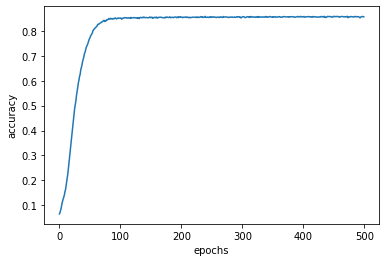

In [12]:
plt.plot(history_model2.history['acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [15]:
# predict next 10 words given seed_text using bidirectional LSTM
seed_text = 'Courtin pretty maids in the evening'

for _ in range(next_words):
    textword_list = tokenizer.texts_to_sequences([seed_text])[0]
    textword_list = pad_sequences([textword_list], maxlen=max_seqlen-1, padding='pre')
    print(textword_list)
    predicted = model2.predict_classes(textword_list, verbose=0)
    
    output_word = ''
    for word, index in tokenizer.word_index.items():
        if predicted == index:
            output_word = word
            break
    seed_text += ' '+output_word
print(seed_text)        

[[   0    0    0    0    0    0    0    0    0 1036  187 2686    8    1
   393]]
[[   0    0    0    0    0    0    0    0 1036  187 2686    8    1  393
  2146]]
[[   0    0    0    0    0    0    0 1036  187 2686    8    1  393 2146
    84]]
[[   0    0    0    0    0    0 1036  187 2686    8    1  393 2146   84
     1]]
[[   0    0    0    0    0 1036  187 2686    8    1  393 2146   84    1
   489]]
[[   0    0    0    0 1036  187 2686    8    1  393 2146   84    1  489
   423]]
[[   0    0    0 1036  187 2686    8    1  393 2146   84    1  489  423
     6]]
[[   0    0 1036  187 2686    8    1  393 2146   84    1  489  423    6
     5]]
[[   0 1036  187 2686    8    1  393 2146   84    1  489  423    6    5
   276]]
[[1036  187 2686    8    1  393 2146   84    1  489  423    6    5  276
   347]]
Courtin pretty maids in the evening moves over the leaves glen of a ones found delight
